# Lab 5 - Dependency parsing
Laboration 5 in EDAN20 @ LTH - http://cs.lth.se/edan20/coursework/assignment-5/

Author: Jonatan Kronander

## Objectives
The objectives of this assignment are to:
* Know what a dependency graph is
* Understand the principles of Nivre's parsing mechanisms
* Extend Nivre's parser with a guiding predicate that parses an annotated dependency graph
* Extract features to learn parsing actions from an annotated corpus
* Write a short report on your results
* In this assignment, you will only generate the machine-learning models from the extracted features. You will complete the parser and apply it in the next assignment.

This assignment is inspired by the shared task of the Tenth conference on computational natural language learning,CONLL-X, and uses a subset of their data. The conference site contains a description of multilingual dependency parsing, reference papers, training and test sets for a variety of languages, as well as evaluation programs. See also CONLL 2007, on the same topic.

Please note that the original CoNLL-X site is down. To access the pages, use the Archive.org site: https://web.archive.org/web/20161105025307/http://ilk.uvt.nl/conll/ and to download the data sets, use the local copies.

In this session, you will implement a dependency parser for Swedish. Should you want to use another corpus, please tell me in advance.

## Choosing a training and a test sets

Use the CONLL-X Swedish corpus. Download the tar archives containing the training and test sets for Swedish and uncompress them: 
http://fileadmin.cs.lth.se/cs/Education/EDAN20/corpus/conllx/sv/swedish_talbanken05_train.conll http://fileadmin.cs.lth.se/cs/Education/EDAN20/corpus/conllx/sv/swedish_talbanken05_test_blind.conll http://fileadmin.cs.lth.se/cs/Education/EDAN20/corpus/conllx/sv/swedish_talbanken05_test.conll

In [1]:
from urllib.request import urlopen

b_train_text = urlopen("http://fileadmin.cs.lth.se/cs/Education/EDAN20/corpus/conllx/sv/swedish_talbanken05_train.conll").read() # Open file and read
train_text = str(b_train_text,'utf-8')

b_test_text = urlopen("http://fileadmin.cs.lth.se/cs/Education/EDAN20/corpus/conllx/sv/swedish_talbanken05_test.conll").read() # Open file and read
test_text = str(b_test_text,'utf-8')

b_blind_test_text = urlopen("http://fileadmin.cs.lth.se/cs/Education/EDAN20/corpus/conllx/sv/swedish_talbanken05_test_blind.conll").read() # Open file and read
blind_test_text = str(b_blind_test_text,'utf-8')

In [2]:
f_out = open('train.conll', 'w')

for sentence in train_text:   
    f_out.write(sentence)
f_out.close()

f_out = open('test.conll', 'w')

for sentence in test_text:   
    f_out.write(sentence)
f_out.close()

f_out = open('test_blind.conll', 'w')

for sentence in blind_test_text:   
    f_out.write(sentence)
f_out.close()

## Nivre's parser

For each sentence with a projective dependency graph, there is an action sequence that enables Nivre's parser to generate this graph. Gold standard parsing corresponds to the sequence of parsing actions, left-arc (la), right-arc (ra), shift (sh), and reduce (re) that produces the manually-obtained, gold standard, graph.

Using an annotated corpus, we can derive all the action sequences producing the manually-parsed sentences (provided that they are projective). We can then train a classifier to predict an action from a current parsing context. To be able to predict the next action from a given parsing state, gold standard parsing must also extract feature vectors at each step of the parsing procedure. The simplest parsing context corresponds to words' part of speech on the top of the stack and head of the input list (the queue).

Once the data collected, the training procedure will produce a 4-class classifier that you will embed in Nivre's parser to choose the next action. During parsing, Nivre's parser will call the classifier to choose the next action in the set {la, ra, sh, re} using the current context.

#### 1.Run the dparser.py program.

In [2]:
import transition
import conll
import dparser

In [3]:
column_names_2006 = ['id', 'form', 'lemma', 'cpostag', 'postag', 'feats', 'head', 'deprel', 'phead', 'pdeprel']

sentences = conll.read_sentences("train.conll")
    
formatted_corpus = conll.split_rows(sentences, column_names_2006)

In [4]:
"""
Code from dparser main()
"""
sent_cnt = 0
for sentence in formatted_corpus:
    sent_cnt += 1
    #if sent_cnt % 1000 == 0:
        #print(sent_cnt, 'sentences on', len(formatted_corpus), flush=True)
    stack = []
    queue = list(sentence)
    graph = {}
    graph['heads'] = {}
    graph['heads']['0'] = '0'
    graph['deprels'] = {}
    graph['deprels']['0'] = 'ROOT'
    transitions = []
    while queue:
        stack, queue, graph, trans = dparser.reference(stack, queue, graph)
        transitions.append(trans)
    stack, graph = transition.empty_stack(stack, graph)
    #print('Equal graphs:', transition.equal_graphs(sentence, graph))

    # Poorman's projectivization to have well-formed graphs.
    for word in sentence:
        word['head'] = graph['heads'][word['id']]
    #print(transitions)
    #print(graph)

In [24]:
print(sentences[2])

1	Jag	_	PO	PO	_	2	SS	_	_
2	tycker	_	VV	VV	_	0	ROOT	_	_
3	det	_	PO	PO	_	2	OO	_	_
4	inte	_	AB	AB	_	2	NA	_	_
5	.	_	IP	IP	_	2	IP	_	_


#### 2. Understand from the slides and the program how Nivre's parser is extended to carry out a gold standard parsing. Given a manually-annotated dependency graph, what are the conditions on the stack and the current input list -- the queue -- to execute left-arc, right-arc, shift, or reduce? Start with left-arc and right-arc, which are the simplest ones. https://github.com/pnugues/ilppp/blob/master/slides/EDAN20_ch13.pdf

Example: "ROOT jag tycker det inte"

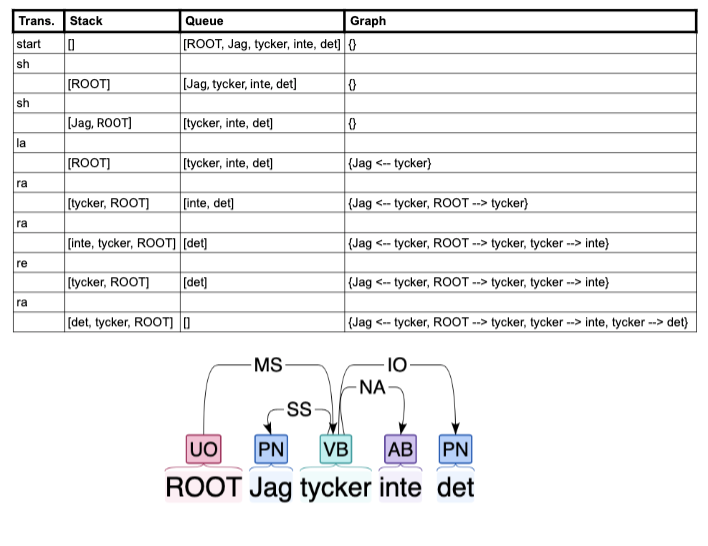

#### 3. The parser can only deal with projective sentences. In the case of a nonprojective one, the parsed graph and the manually-annotated sentence are not equal. Examine one such sentence and explain why it is not projective. Take a short one (the shortest).

**Projective:** Each pair of words (Dep, Head), directly connected, is only separated by direct or indirect dependents of Dep or Head

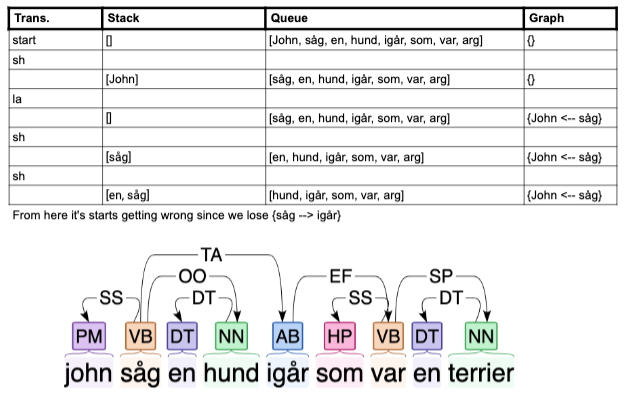

#### 4.You will use three feature sets to build your models:
* The top of the stack and the first word of the input list (word forms and parts of speech);
* The two first words and POS on the top of the stack and the two first words and POS of the input list;
* A feature vector that you will design that will extend the previous one with at least two features. You can read this paper (Table 6) to build your vector. In this paper, Sect. 4 contains the description of the feature codes: LEX, POS, fw, etc.

#### 5. Nivre's parser sets constraints to actions. Name a way to encode these constraints as features. Think of Boolean features.


## Feature 1

In [ ]:
def extract_1(stack, queue, graph, feature_names, sentence):
    """
    Extract the features from one sentence returns a list of dictionaries X
    """
    features = {}
    
    for feature in feature_names:
        if feature == 'stack0_POS':
            feature['stack0_POS'] = stack[0]['postag']
        if feature == 'stack1_POS':
            features['stack1_POS'] = stack[1]["postag"]
        if feature == 'stack0_word':
            features["stack0_word"] = stack[0]["form"]
    

    
    features['canReduce'] = transition.can_reduce(stack, graph)
    features['canLeftArc'] = transition.can_leftarc(stack, graph)
    
    # We pad the sentence to extract the context window more easily
    #start = "BOS BOS BOS\n"
    #end = "\nEOS EOS EOS"
    #start *= w_size
    #end *= w_size
    #sentence = start + sentence
    #sentence += end
    
    # Each sentence is a list of rows
    sentence = sentence.splitlines()
    padded_sentence = list()
    for line in sentence:
        line = line.split()
        padded_sentence.append(line)
    # print(padded_sentence)

    # We extract the features and the classes
    # X contains is a list of features, where each feature vector is a dictionary
    # y is the list of classes
    X = list()
    y = list()
    for i in range(len(padded_sentence) - 2 * w_size):
        # x is a row of X
        x = list()
        # The words in lower case
        for j in range(2 * w_size + 1):
            x.append(padded_sentence[i + j][0].lower())
        # The POS
        for j in range(2 * w_size + 1):
            x.append(padded_sentence[i + j][1])
        # The chunks (Up to the word)
        """
        for j in range(w_size):
            feature_line.append(padded_sentence[i + j][2])
        """
        # We represent the feature vector as a dictionary
        X.append(dict(zip(feature_names, x)))
        # The classes are stored in a list
        y.append(padded_sentence[i + w_size][2])
    return X, y
    
    
    return features
